In [1]:
import os, sys    # for handling paths
import h5py as h5  #for handling data format
import numpy as np
import matplotlib.pyplot as plt
import mesa_reader as mr 
import pandas as pd
import matplotlib.colors as colors
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
})


rsol = 6.96e10 #cm
msol = 1.989e33 #grams
lsol = 3.839e33 #ergs

#this is for when the separation of the 2 stellar centers is unity
#Q is the mass ratio
def r_l(q):
    return (0.49*q**(2/3))/(0.6*q**(2/3) + np.log(1+q**(1/3)))


def M_conv_new(T_eff, Tonset, Tmin, M_conv_max, param):
    return M_conv_max/(1+np.exp((-2*param*T_eff + param*Tmin + param*Tonset)/(Tmin - Tonset)))


def M_conv_max_func(star_mass, M_core_max,gamma):
    return star_mass - (1+gamma)*M_core_max

gamma = 0.05 


# where M is the mass of the system so Md + M_2
#during main sequence initial speration is 0 due to phase 1, and the final mas of the doner is 0 so the expression is infinite
#multiplying 0 and inf results in NAN values!
def momentum_af(a_i, M_i, M_f, Md_i, Md_f, M_2):
    return a_i * (M_i/M_f) * (Md_i/Md_f)**2 * np.exp(-2*(Md_i- Md_f)/M_2)

#during main sequence the core mass is 0 and hence the final seperation will also be 0!
def energy_af(M_core, M_d, M_env, M_2, r_d, a_i, l, alpha):
    denum = (2*M_d*M_env)/(l*alpha*r_d*M_2) + M_d/a_i
    return M_core/denum  


def alpha_lambda(M_core, M_d, M_env, M_2, r_d, a_i, a_f):
    denum = r_d/2*(-(M_d*M_2)/a_i + M_core*M_2/a_f)
    numer = M_d*M_env
    return numer/denum 
                     
def quad(x, a, b ,c):
    return a*x**2 + b*x + c

def linear(xdata, m, b):
    return m*xdata + b


param = 3.0
#for compass we need to set it earlier beciase they dont get cold enough compared to the Mesa models 
Tonset = 5000

The aim is to plot a hr diagram of stellar curves coloured with effective alpha. 
at each point on the HR diagram there will be a radius associated with it and assume it is overfilling its roche lobe. When R_d == R_l that will give us an initial separation thus allowing use to get an intial separation for the energy formalism. 

we will keep the mass ratio constant for the curves 

Use this block to get the maximum and minimum alpha_ce_l values to scale the colour too. 

In [2]:
data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda
index = np.arange(32) #this is to load compass 
# q = 20 #mass ratio of 5:1 where the doner is 5 times bigger. 
M_2 = 10


min_alpha_l_ce = np.inf
max_alpha_l_ce = -np.inf

for i in index[8:16]: 
    #read in data
    pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
    pathToh5 = pathToOutput + 'SSE_Detailed_Output_' + str(i) + '.h5'
    Data = h5.File(pathToh5, 'r')
    
    #get values of interest
    z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
    M_i = round(Data['Mass'][()][0]) #initial mass
#     M_2 = M_i/q #define the mass of the companion for constat mass ratio 
    print(z, i, M_i)
    #change from constant companion mass to q vice versa 
    q = M_i/M_2
    
    #parameters of interest
    St = Data['Stellar_Type'][()]
    L = Data['Luminosity'][()][:-1]
    Mass = Data['Mass'][()][:-1]
    Teff = Data['Teff'][()][:-1]
    Tmin = min(Teff)
    radius = Data['Radius'][()][:-1]
    M_Hecore = Data['Mass_He_Core'][()][:-1]
    
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    
    #Define convective and intermediate mass
    MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
    Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
    M_inter = Mass - Mconv - M_Hecore
    
    #define lambda for the stars evolution
    Ehe_gradient = quad(np.log10(z),*data.Ehe_linear_grad_quad_fit)
    intercept = data.Ehe_average_intercept[0]
    grad = data.Ehe_average_grad[0]
    log_l = linear(Mconv/MaxMconv, grad, linear(M_i, Ehe_gradient, intercept))
    
    # Find the index corresponding to the value closest to 0.3
    index = np.argmin(np.abs(Mconv/MaxMconv - 0.3))

    # Set the values of the 'list' to the value at index for xdata < 0.3
    log_l_values = log_l.copy()
    log_l_values[Mconv/MaxMconv < 0.3] = log_l[index]
    l_values = np.exp(log_l_values)
#     plt.plot(Mconv/MaxMconv, l_values) #Check plot to make sure its good


    #final separation for part 1 
    E_af = energy_af(M_Hecore, Mass, Mconv, M_2, radius, a_i, l_values, alpha = 1.0) #the final seperation will be in solar radius

    #now we have the final separation from part 2
    M_af = momentum_af(E_af, (M_Hecore + M_inter + M_2), (M_Hecore + M_2), (M_Hecore + M_inter), M_Hecore, M_2)
    
    #ge tthe expected alpha values
    alpha_l_ce = alpha_lambda(M_Hecore, Mass, (Mconv+M_inter), M_2, radius, a_i, M_af)
    alpha_l_ce = np.nan_to_num(alpha_l_ce, nan=0.0)  # Replace NaN with 1.0
    print(alpha_l_ce[-1])
    min_alpha_l_ce = min(min_alpha_l_ce, np.min(alpha_l_ce))
    max_alpha_l_ce = max(max_alpha_l_ce, np.max(alpha_l_ce))

0.0142 8 4
2.025200007941314
0.0142 9 8
1.9915246438139371
0.0142 10 12
1.8089398157740242
0.0142 11 16
1.7028039050070738
0.0142 12 20
1.6260953496499793
0.0142 13 24
1.5641798086684648
0.0142 14 28
1.5110191363100638
0.0142 15 32
1.46365448150037


/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


Now we have the min/max values we use this block to plot it. Its vertually the same just has the plot routine in it. 

-6464.7113534223445 3351.8628882231974


/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


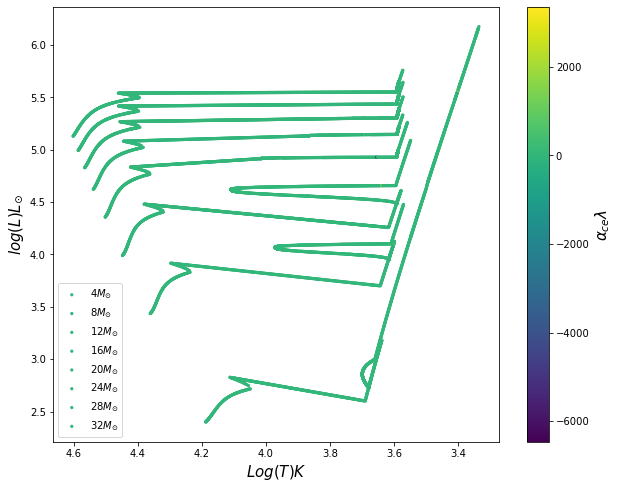

In [6]:
plt.figure(figsize = (10,8))
color_map = plt.cm.get_cmap('viridis',512)#choose colour of the map here 
data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda
index = np.arange(32) #this is to load compass 

vmin = min_alpha_l_ce
vmax = max_alpha_l_ce
# vmin = max(min_alpha_l_ce,0)
# vmax = min(max_alpha_l_ce,10)
print(vmin,vmax)

for i in index[8:16]: 
    #read in data
    pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
    pathToh5 = pathToOutput + 'SSE_Detailed_Output_' + str(i) + '.h5'
    Data = h5.File(pathToh5)
    
    #get values of interest
    z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
    M_i = round(Data['Mass'][()][0]) #initial mass
#     M_2 = M_i/q #define the mass of the companion for constat mass ratio 
    
    #change from constant companion mass to q vice versa 
    q = M_i/M_2
    
    #parameters of interest
    St = Data['Stellar_Type'][()]
    L = Data['Luminosity'][()][:-1]
    Mass = Data['Mass'][()][:-1]
    Teff = Data['Teff'][()][:-1]
    Tmin = min(Teff)
    radius = Data['Radius'][()][:-1]
    M_Hecore = Data['Mass_He_Core'][()][:-1]
    
#     print(z)
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    
    #Define convective and intermediate mass
    MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
    Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
    M_inter = Mass - Mconv - M_Hecore
    
    #define lambda for the stars evolution
    Ehe_gradient = quad(np.log10(z),*data.Ehe_linear_grad_quad_fit)
    intercept = data.Ehe_average_intercept[0]
    grad = data.Ehe_average_grad[0]
    log_l = linear(Mconv/MaxMconv, grad, linear(M_i, Ehe_gradient, intercept))
    
    # Find the index corresponding to the value closest to 0.3
    index = np.argmin(np.abs(Mconv/MaxMconv - 0.3))

    # Set the values of the 'list' to the value at index for xdata < 0.3
    log_l_values = log_l.copy()
    log_l_values[Mconv/MaxMconv < 0.3] = log_l[index]
    l_values = np.exp(log_l_values)
#     plt.plot(Mconv/MaxMconv, l_values) #Check plot to make sure its good
#     plt.show()


    #final separation for part 1 
    E_af = energy_af(M_Hecore, Mass, Mconv, M_2, radius, a_i, l_values, alpha = 1.0) #the final seperation will be in solar radius

    #now we have the final separation from part 2
    M_af = momentum_af(E_af, (M_Hecore + M_inter + M_2), (M_Hecore + M_2), (M_Hecore + M_inter), M_Hecore, M_2)
    
    #ge tthe expected alpha values
    alpha_l_ce = alpha_lambda(M_Hecore, Mass, (Mconv+M_inter), M_2, radius, a_i, M_af)
    alpha_l_ce = np.nan_to_num(alpha_l_ce, nan=0.0)  # Replace NaN with 1.0
    
    plt.scatter(np.log10(Teff), np.log10(L), c=alpha_l_ce, s=5, cmap=color_map, vmin=vmin, vmax=vmax, label=str(M_i) + "$M_{\odot}$")
#     print(M_i)
#     print(np.log10(Teff[0]),np.log10(L[0]))
plt.xlabel('$Log(T) K$',fontsize = 15)
plt.ylabel('$log(L) L_{\odot}$',fontsize = 15)

# Create the colorbar based on the scatter plot
cbar = plt.colorbar()
cbar.set_label('$\\alpha_{ce}\lambda$',fontsize = 15)
plt.legend()
plt.gca().invert_xaxis()
cbar.mappable.set_clim(vmin, vmax) 
plt.savefig('/home/lewis/Documents/Honours_Research/data/plots/Plots_for_paper/Alpha_ce_plots/M_c_'+ str(M_2) +'.pdf')
# plt.annotate('$4M_{\odot}$', xy=(4.18, 2.39), xytext=(4.4, 2.4), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$8M_{\odot}$', xy=(4.36, 3.43), xytext=(4.55, 3.4), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$12M_{\odot}$', xy=(4.44, 3.98), xytext=(4.65, 4.0), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$16M_{\odot}$', xy=(4.50, 4.36), xytext=(4.3, 4.6), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$20M_{\odot}$', xy=(4.53, 4.62), xytext=(4.7, 4.7), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$24M_{\odot}$', xy=(4.56, 4.83), xytext=(4.7, 4.7), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$28M_{\odot}$', xy=(4.58, 4.99), xytext=(4.7, 4.7), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
# plt.annotate('$32M_{\odot}$', xy=(4.60, 5.13), xytext=(4.7, 4.7), fontsize = '14', arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show()

#     plt.xlim(0,10)
#     plt.ylim(0,10)

    
    

In [20]:
np.log10(6300)

3.7993405494535817

/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


0.0142
0.0142
0.0142
5.111092358689747e-42 7.683381609553637
0.0142
0.0142
0.0142


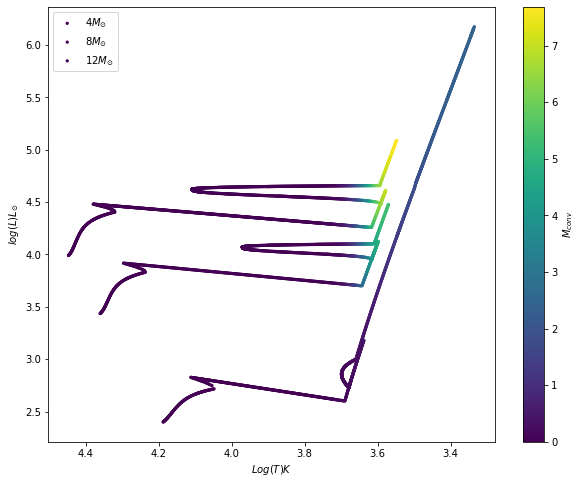

In [47]:
plt.figure(figsize = (10,8))

data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda
index = np.arange(32) #this is to load compass 
min_M_conv = np.inf
max_M_conv = -np.inf

for i in index[8:11]: 
    #read in data
    pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
    pathToh5 = pathToOutput + 'SSE_Detailed_Output_' + str(i) + '.h5'
    Data = h5.File(pathToh5)
    
    #get values of interest
    z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
    M_i = round(Data['Mass'][()][0]) #initial mass
    M_2 = M_i/q #define the mass of the companion for constat mass ratio 
    
    #parameters of interest
    St = Data['Stellar_Type'][()]
    L = Data['Luminosity'][()][:-1]
    Mass = Data['Mass'][()][:-1]
    Teff = Data['Teff'][()][:-1]
    Tmin = min(Teff)
    radius = Data['Radius'][()][:-1]
    M_Hecore = Data['Mass_He_Core'][()][:-1]
    
    print(z)
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    
    #Define convective and intermediate mass
    MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
    Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
    M_inter = Mass - Mconv - M_Hecore
    
    min_M_conv = min(min_M_conv, np.min(Mconv))
    max_M_conv = max(max_M_conv, np.max(Mconv))
    
vmin = min_M_conv
vmax = max_M_conv
print(vmin,vmax)

for i in index[8:11]: 
    #read in data
    pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
    pathToh5 = pathToOutput + 'SSE_Detailed_Output_' + str(i) + '.h5'
    Data = h5.File(pathToh5)
    
    #get values of interest
    z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
    M_i = round(Data['Mass'][()][0]) #initial mass
    M_2 = M_i/q #define the mass of the companion for constat mass ratio 
    
    #parameters of interest
    St = Data['Stellar_Type'][()]
    L = Data['Luminosity'][()][:-1]
    Mass = Data['Mass'][()][:-1]
    Teff = Data['Teff'][()][:-1]
    Tmin = min(Teff)
    radius = Data['Radius'][()][:-1]
    M_Hecore = Data['Mass_He_Core'][()][:-1]
    
    print(z)
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    
    #Define convective and intermediate mass
    MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
    Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
    M_inter = Mass - Mconv - M_Hecore
    
    plt.scatter(np.log10(Teff), np.log10(L), c=Mconv, s=5, cmap=color_map, vmin=vmin, vmax=vmax, label=str(M_i) + "$M_{\odot}$")

plt.xlabel('$Log(T) K$')
plt.ylabel('$log(L) L_{\odot}$')

# Create the colorbar based on the scatter plot
cbar = plt.colorbar()
cbar.set_label('$M_{conv}$')
plt.legend()
plt.gca().invert_xaxis()
cbar.mappable.set_clim(vmin, vmax) 
plt.show()


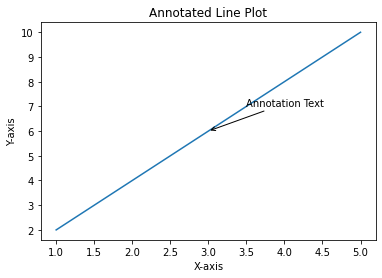

In [14]:
# Generate some sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Create a plot
plt.plot(x, y, label='Data Line')

# Add an annotation near the line
plt.annotate('Annotation Text', xy=(3, 6), xytext=(3.5, 7),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Set labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Annotated Line Plot')

# Display the plot
plt.show()

# Now make some 2D heat map of alpha values for a star over a parameters space of radius vs mass ratio (Q values) 



Think about using mass ratio defined by a certain range. Start with 16msol 1zsol star. index i = 11 

/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monoto

0.0142
5.779244374737979


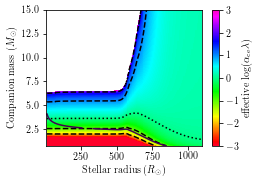

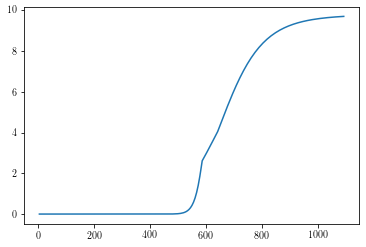

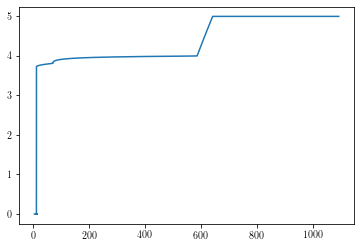

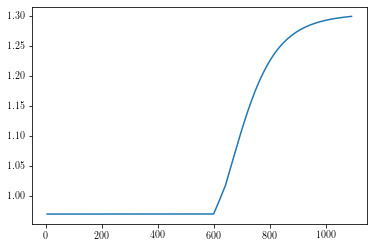

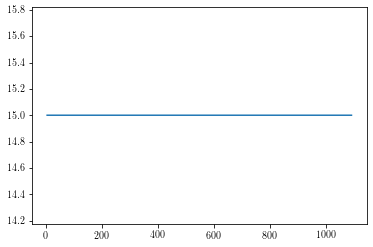

In [10]:
lambda_data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda

pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_2/Detailed_Output/'
pathToh5 = pathToOutput + 'SSE_Detailed_Output_0.h5'
Data = h5.File(pathToh5)

z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
print(z)
param = 4.6
Tonset = quad(np.log10(z),-139.75, -981.66, 2798.282)
gamma = linear(np.log10(z),-0.02090868,  0.003765)


M_i = round(Data['Mass'][()][0]) #initial mass
#get parameters 
L = Data['Luminosity'][()][:-1]
Mass = Data['Mass'][()][:-1]
Teff = Data['Teff'][()][:-1]
Tmin = min(Teff)
radius = Data['Radius'][()][:-1]
M_Hecore = Data['Mass_He_Core'][()][:-1]

#Define convective and intermediate mass
MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
M_inter = Mass - Mconv - M_Hecore

#define lambda for the stars evolution
Ehe_gradient = quad(np.log10(z),*lambda_data.Ehe_linear_grad_quad_fit)
intercept = lambda_data.Ehe_average_intercept[0]
grad = lambda_data.Ehe_average_grad[0]
log_l = linear(Mconv/MaxMconv, grad, linear(M_i, Ehe_gradient, intercept))
# Find the index corresponding to the value closest to 0.3
index = np.argmin(np.abs(Mconv/MaxMconv - 0.3))

# Set the values of the 'list' to the value at index for xdata < 0.3
log_l_values = log_l.copy()
log_l_values[Mconv/MaxMconv < 0.3] = log_l[index]
l_values = np.exp(log_l_values)
# l_values = np.ones(M_inter.shape)
# plt.plot(Mconv/MaxMconv, l_values) #Check plot to make sure its good
plt.show()


# q_list = np.linspace(0.5,10,10)
# M_2_list = M_i/q_list

M_2_list = np.linspace(0.7, 15, 500)
q_list = M_i/M_2_list

#crete the mesh grid 
R,companion_mass = np.meshgrid(radius,M_2_list)

alpha_list = np.empty_like(R)
E_af_list = np.empty_like(R)
M_af_list = np.empty_like(R)
a_i_list = np.empty_like(R)


for i, q in enumerate(q_list):
    #get companion mass
    M_2 = M_i/q
    
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    

    #final separation for part 1 
    E_af = energy_af(M_Hecore, Mass, Mconv, M_2, radius, a_i, l_values, alpha = 1.0) #the final seperation will be in solar radius

    #now we have the final separation from part 2
    M_af = momentum_af(E_af, (M_Hecore + M_inter + M_2), (M_Hecore + M_2), (M_Hecore + M_inter), M_Hecore, M_2)
   
    #get the expected alpha values
    alpha_l_ce = alpha_lambda(M_Hecore, Mass, (Mconv+M_inter), M_2, radius, a_i, M_af)

    alpha_list[i, :] = alpha_l_ce
    a_i_list[i,:] = a_i
    E_af_list[i,:] = E_af
    M_af_list[i,:] = M_af

# Assuming you have already defined the variables R, companion_mass, and alpha_list
alpha_list = np.nan_to_num(alpha_list, nan=0.0)  



alpha_list[alpha_list < 0] = 0
log_alpha_list = np.log10(alpha_list)
print(log_alpha_list.max())


#set figure
plt.figure(figsize = (3.5, 2.5))
# plt.title('Effective $\\alpha_{ce}\lambda$ for a '+ str(M_i) + '$M_{\odot}$ solar metalicity star')
plt.xlabel('Stellar radius ($R_{\odot}$)')
plt.ylabel('Companion mass ($M_{\odot}$)')

plt.pcolormesh(R, companion_mass, log_alpha_list, cmap='gist_rainbow')
cbar = plt.colorbar()
cbar.mappable.set_clim(-3, 3)
cbar.set_label('effective $\log(\\alpha_\mathrm{ce}\lambda)$')
#contours
contour_levels = [-2, -1, 0, 1, 2]
contour_labels_str = ['', '', '', '', '']  # Manually specify the labels corresponding to the contour levels

# Create the contour lines
contours = plt.contour(R, companion_mass, log_alpha_list, levels=contour_levels, colors=['black','black','black','black','black'],linestyles =['--','--','dotted','--','--'] * len(contour_levels))

# Create a dictionary to map contour levels to labels
# label_dict = dict(zip(contour_levels, contour_labels_str))

# Manually set contour labels using the dictionary
# plt.clabel(contours, inline=True, colors='black')#, fmt=label_dict)

contour_Rsol_level = [1]
contour_Rsol_label = ['']
contour_Rsol = plt.contour(R, companion_mass, M_af_list, levels=contour_Rsol_level)
label_dict_Rsol = dict(zip(contour_Rsol_level, contour_Rsol_label))
plt.clabel(contour_Rsol, inline=True, colors='black', fmt=label_dict_Rsol)


plt.savefig('/home/lewis/Documents/Honours_Research/data/plots/Plots_for_paper/alpha/alpha_15M_1Z.png',bbox_inches = 'tight',dpi=300)

plt.show()


plt.plot(radius,Mconv)

plt.show()


plt.plot(radius,M_Hecore)
plt.show()

plt.plot(radius,l_values)
plt.show()


plt.plot(radius,Mass)
plt.show()


Use this part for the plots in my presentation 

/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell

0.0142


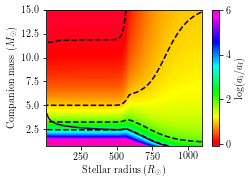

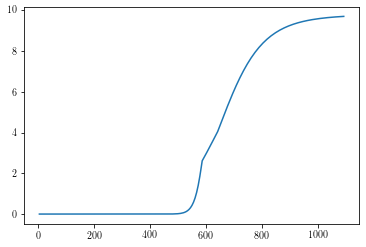

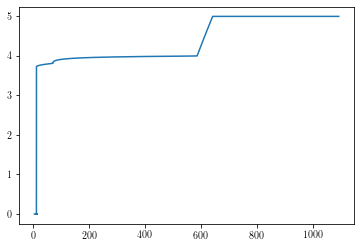

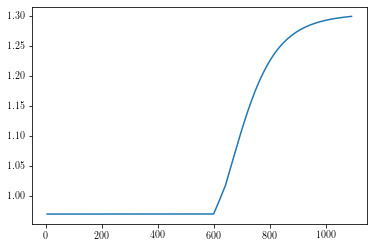

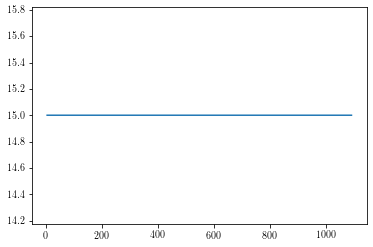

In [7]:
lambda_data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda

pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_2/Detailed_Output/'
pathToh5 = pathToOutput + 'SSE_Detailed_Output_0.h5'
Data = h5.File(pathToh5)

z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
print(z)
param = 4.6
Tonset = quad(np.log10(z),-139.75, -981.66, 2798.282)
gamma = linear(np.log10(z),-0.02090868,  0.003765)


M_i = round(Data['Mass'][()][0]) #initial mass
#get parameters 
L = Data['Luminosity'][()][:-1]
Mass = Data['Mass'][()][:-1]
Teff = Data['Teff'][()][:-1]
Tmin = min(Teff)
radius = Data['Radius'][()][:-1]
M_Hecore = Data['Mass_He_Core'][()][:-1]

#Define convective and intermediate mass
MaxMconv = M_conv_max_func(Mass[-2], M_Hecore[-2],gamma) #use the final star and core mass to get max M_conv
Mconv = M_conv_new(Teff, Tonset, Tmin, MaxMconv, param)
M_inter = Mass - Mconv - M_Hecore

#define lambda for the stars evolution
Ehe_gradient = quad(np.log10(z),*lambda_data.Ehe_linear_grad_quad_fit)
intercept = lambda_data.Ehe_average_intercept[0]
grad = lambda_data.Ehe_average_grad[0]
log_l = linear(Mconv/MaxMconv, grad, linear(M_i, Ehe_gradient, intercept))
# Find the index corresponding to the value closest to 0.3
index = np.argmin(np.abs(Mconv/MaxMconv - 0.3))

# Set the values of the 'list' to the value at index for xdata < 0.3
log_l_values = log_l.copy()
log_l_values[Mconv/MaxMconv < 0.3] = log_l[index]
l_values = np.exp(log_l_values)
# l_values = np.ones(M_inter.shape)
# plt.plot(Mconv/MaxMconv, l_values) #Check plot to make sure its good
plt.show()


# q_list = np.linspace(0.5,10,10)
# M_2_list = M_i/q_list

M_2_list = np.linspace(0.7, 15, 500)
q_list = M_i/M_2_list

#crete the mesh grid 
R,companion_mass = np.meshgrid(radius,M_2_list)

alpha_list = np.empty_like(R)
E_af_list = np.empty_like(R)
M_af_list = np.empty_like(R)
a_i_list = np.empty_like(R)

for i, q in enumerate(q_list):
    #get companion mass
    M_2 = M_i/q
    
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    a_i_list[i,:] = a_i
    

    #final separation for part 1 
    E_af = energy_af(M_Hecore, Mass, Mconv, M_2, radius, a_i, l_values, alpha = 1.0) #the final seperation will be in solar radius
    E_af_list[i,:] = E_af 
    #now we have the final separation from part 2
    M_af = momentum_af(E_af, (M_Hecore + M_inter + M_2), (M_Hecore + M_2), (M_Hecore + M_inter), M_Hecore, M_2)
    M_af_list[i,:] = M_af
    #get the expected alpha values
    alpha_l_ce = alpha_lambda(M_Hecore, Mass, (Mconv+M_inter), M_2, radius, a_i, M_af)

    alpha_list[i, :] = alpha_l_ce
        

# # Assuming you have already defined the variables R, companion_mass, and alpha_list
# alpha_list = np.nan_to_num(alpha_list, nan=0.0)  
# alpha_list[alpha_list < 0] = 0
# log_alpha_list = np.log10(alpha_list)
#final separation coresponding to 1rsol (a_i is in rsun units so M_af are in solar units so when M_af = 1  curve.)


ratio = a_i_list/M_af_list
log_ratio = np.log10(ratio)
log_ratio = np.nan_to_num(log_ratio, nan=-np.inf) 
#set figure
plt.figure(figsize = (3.5, 2.5))
# plt.title( str(M_i) + '$M_{\odot}$ at $Z_i = Z_{\odot}$')
plt.xlabel('Stellar radius ($R_{\odot}$)')
plt.ylabel('Companion mass ($M_{\odot}$)')
#colourplot
plt.pcolormesh(R, companion_mass, log_ratio, cmap='gist_rainbow')
cbar = plt.colorbar()
cbar.mappable.set_clim(-0.1, 6)
cbar.set_label('$\log(a_\mathrm{i}/a_\mathrm{f})$')
#contour for Af = Rsol

contour_Rsol_level = [1]
contour_Rsol_label = ['$1R_{\odot}$']
contour_Rsol = plt.contour(R, companion_mass, M_af_list, levels=contour_Rsol_level)
# label_dict_Rsol = dict(zip(contour_Rsol_level, contour_Rsol_label))
# plt.clabel(contour_Rsol, inline=True, fontsize='large', colors='black', fmt=label_dict_Rsol)

#contours
contour_levels = [0, 1, 2, 3]
contour_labels_str = ['0', '1','2','3']  # Manually specify the labels corresponding to the contour levels

# Create the contour lines
contours = plt.contour(R, companion_mass, log_ratio, levels=contour_levels, colors=['black', 'black','black','black'],linestyles =['--','--','--','--'] * len(contour_levels))

# # Create a dictionary to map contour levels to labels
label_dict = dict(zip(contour_levels, contour_labels_str))

# # Manually set contour labels using the dictionary
# plt.clabel(contours, inline=True, fontsize='large', colors='black', fmt=label_dict)

plt.savefig('/home/lewis/Documents/Honours_Research/data/plots/Plots_for_paper/alpha/ratio_plot_15M.png',bbox_inches = 'tight',dpi=400)

plt.show()


plt.plot(radius,Mconv)

plt.show()


plt.plot(radius,M_Hecore)
plt.show()

plt.plot(radius,l_values)
plt.show()


plt.plot(radius,Mass)
plt.show()


In [16]:
pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
pathToh5 = pathToOutput + 'SSE_Detailed_Output_12.h5'
Data = h5.File(pathToh5)
print(list(Data.keys()))

['Age', 'Dominant_Mass_Loss_Rate', 'Luminosity', 'Mass', 'Mass_0', 'Mass_CO_Core', 'Mass_Core', 'Mass_He_Core', 'Mdot', 'Metallicity@ZAMS', 'Radius', 'Radius@ZAMS', 'Record_Type', 'Stellar_Type', 'Teff', 'Time', 'dT', 'tMS']


/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
he_core = Data['Mass_He_Core'][()]
core = Data['Mass_Core'][()]


5.56255401216137


/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/home/lewis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


0.0142
16
[11.93358557 11.93333148 11.93307739 11.9328233  11.9325692  11.93231511
 11.93206102 11.93180693 11.93155283 11.93129874 11.93104465 11.93079056
 11.93053647 11.93028237 11.93002828 11.92977419 11.9295201  11.929266
 11.92901191 11.92875782 11.92850373 11.92824963 11.92799554 11.92774145
 11.92748736 11.92723327 11.92697917 11.92672508 11.92647099 11.9262169
 11.9259628  11.92570871 11.92545462 11.92520053 11.92494643 11.92469234
 11.92443825 11.92418416 11.92393006 11.92367597 11.92342188 11.92316779
 11.9229137  11.9226596  11.92240551 11.92215142 11.92189733 11.92164323
 11.92138914 11.92113505]
0.0
inf
[[       inf        inf        inf ... 2.84595876 2.84595876 2.84595876]
 [       inf        inf        inf ... 2.83044678 2.83044678 2.83044678]
 [       inf        inf        inf ... 2.81555929 2.81555929 2.81555929]
 ...
 [       inf        inf        inf ... 1.75789432 1.75789432 1.75789432]
 [       inf        inf        inf ... 1.75728353 1.75728353 1.75728353]
 [   

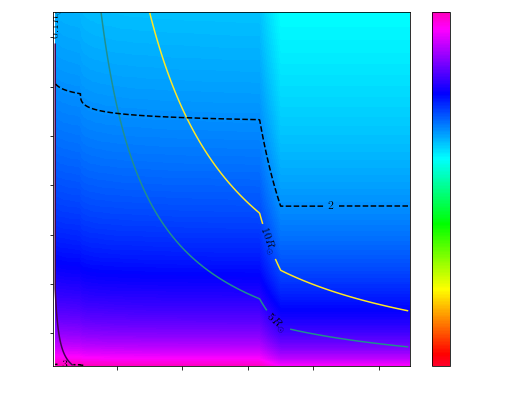

In [96]:
lambda_data = pd.read_csv('/home/lewis/Documents/Honours_Research/data/csv/Lambda/final_params.csv') #fit details for lambda

pathToOutput = '/home/lewis/Documents/Honours_Research/COMPAS-dev/utils/preProcessing/COMPAS_Output_1/Detailed_Output/'
pathToh5 = pathToOutput + 'SSE_Detailed_Output_11.h5'
Data = h5.File(pathToh5)

z = Data['Metallicity@ZAMS'][()][0] #initial metalicity
print(z)


M_i = round(Data['Mass'][()][0]) #initial mass
print(M_i)
#get parameters 
L = Data['Luminosity'][()][:-1]
Mass = Data['Mass'][()][:-1]
Teff = Data['Teff'][()][:-1]
Tmin = min(Teff)
radius = Data['Radius'][()][:-1]
M_Hecore = Data['Mass_He_Core'][()][:-1]
M_env = Mass - M_Hecore
print(M_env[200:250])

M_2_list = np.linspace(0.7, 15, 500)
q_list = M_i/M_2_list

#crete the mesh grid 
R,companion_mass = np.meshgrid(radius,M_2_list)

alpha_list = np.empty_like(R)
E_af_list = np.empty_like(R)
M_af_list = np.empty_like(R)
a_i_list = np.empty_like(R)

for i, q in enumerate(q_list):
    #get companion mass
    M_2 = M_i/q
    
    #define initial seperation
    roche_lobe = r_l(q) #this is the scale factor for initial separation. 
    a_i = radius/roche_lobe
    a_i_list[i,:] = a_i
    

    #final separation for part 1 using entire envelope and lambda = 0.2
    E_af = energy_af(M_Hecore, Mass, M_env, M_2, radius, a_i, 0.2, alpha = 1.0) #the final seperation will be in solar radius
    E_af_list[i,:] = E_af 
    

ratio = a_i_list/E_af_list
print(np.min(E_af_list))
print(np.max(ratio))
log_ratio = np.log10(ratio) 
print(log_ratio)
print(np.min(log_ratio),np.max(log_ratio))
#set figure
plt.figure(figsize = (8, 6.5))
# plt.title( str(M_i) + '$M_{\odot}$ at $Z_i = Z_{\odot}$')
plt.xlabel('Stellar radius ($R_{\odot}$)', fontsize = 20,c = 'white')
plt.ylabel('Companion mass ($M_{\odot}$)', fontsize = 20,c = 'white')
plt.xticks(fontsize=15,c = 'white')
plt.yticks(fontsize=15,c = 'white')
#colourplot
plt.pcolormesh(R, companion_mass, log_ratio, cmap='gist_rainbow')
cbar = plt.colorbar()
cbar.mappable.set_clim(0,3)
cbar.set_label('$log(a_i/a_f)$', fontsize = 20, c = 'white')
cbar.ax.tick_params(axis='y', colors='white', labelsize=15)
#contour for Af = Rsol

contour_Rsol_level = [0.1,5,10]
contour_Rsol_label = ['$0.1R_{\odot}$','$5R_{\odot}$','$10R_{\odot}$']
contour_Rsol = plt.contour(R, companion_mass, E_af_list, levels=contour_Rsol_level)
label_dict_Rsol = dict(zip(contour_Rsol_level, contour_Rsol_label))
plt.clabel(contour_Rsol, inline=True, fontsize='large', colors='black', fmt=label_dict_Rsol)

# #contours
contour_levels = [0, 1, 2, 3]
contour_labels_str = ['0', '1','2','3']  # Manually specify the labels corresponding to the contour levels

# Create the contour lines
contours = plt.contour(R, companion_mass, log_ratio, levels=contour_levels, colors='black',linestyles =['--'] * len(contour_levels))

# # Create a dictionary to map contour levels to labels
label_dict = dict(zip(contour_levels, contour_labels_str))

# Manually set contour labels using the dictionary
plt.clabel(contours, inline=True, fontsize='large', colors='black', fmt=label_dict)

plt.savefig('/home/lewis/Documents/Honours_Research/data/plots/Plots_for_paper/alpha/ratio_plot_energy.png',bbox_inches = 'tight',dpi=400)

plt.show()